In [1]:
# Veri işleme ve görselleştirme kütüphaneleri
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# BioPython (FASTA dosyalarını okumak için)
# Eğer yüklü değilse, aşağıdaki komutu çalıştırabilirsiniz:
# !pip install biopython
from Bio import SeqIO

# Makine öğrenmesi kütüphaneleri
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# PCA (Principal Component Analysis) için
from sklearn.decomposition import PCA

# İleri görselleştirmeler için 3D plot
from mpl_toolkits.mplot3d import Axes3D

# Uyarıları gizlemek için
import warnings
warnings.filterwarnings('ignore')

# Stil ayarları
sns.set(style="whitegrid")
%matplotlib inline


In [3]:
def read_fasta_sequences(fasta_path):
    """
    Belirtilen 'fasta_path' dosyasındaki tüm sekansları okuyup
    liste halinde döndürür.
    """
    sequences = []
    for record in SeqIO.parse(fasta_path, "fasta"):
        seq_str = str(record.seq).upper()  # Tüm harfleri büyük harf yapıyoruz
        sequences.append(seq_str)
    return sequences

# FASTA dosyalarının yolunu belirtin
influenza_fasta = "data/Influenza_Virus.fasta"
sars_cov_2_fasta = "data/SARS-CoV-2.fasta"

# Sekansları okuyalım
influenza_sequences = read_fasta_sequences(influenza_fasta)
sars_cov_2_sequences = read_fasta_sequences(sars_cov_2_fasta)

print("Influenza sekans sayısı:", len(influenza_sequences))
print("SARS-CoV-2 sekans sayısı:", len(sars_cov_2_sequences))


Influenza sekans sayısı: 2000
SARS-CoV-2 sekans sayısı: 2000


In [4]:
# Geçerli nükleotitler
valid_chars = {'A', 'T', 'G', 'C', 'N'}

def clean_sequence(seq, valid_chars=valid_chars):
    """
    Sequence içindeki geçerli harfler dışındakileri 'N' olarak dönüştürür.
    """
    cleaned = []
    for ch in seq:
        if ch in valid_chars:
            cleaned.append(ch)
        else:
            cleaned.append('N')  
    return "".join(cleaned)

# Tüm sekansları temizleyelim
influenza_sequences = [clean_sequence(seq) for seq in influenza_sequences]
sars_cov_2_sequences = [clean_sequence(seq) for seq in sars_cov_2_sequences]

# Temizlenmiş sekans sayısını kontrol edelim
print("Temizlenmiş Influenza sekans sayısı:", len(influenza_sequences))
print("Temizlenmiş SARS-CoV-2 sekans sayısı:", len(sars_cov_2_sequences))


Temizlenmiş Influenza sekans sayısı: 2000
Temizlenmiş SARS-CoV-2 sekans sayısı: 2000


In [5]:
# Basit bir mapping: A=0, T=1, G=2, C=3, N=4
char_to_int = {'A':0, 'T':1, 'G':2, 'C':3, 'N':4}

def sequence_to_numeric(seq, mapping=char_to_int):
    """
    Verilen 'seq' (string) içindeki karakterleri sayılara dönüştürür
    ve liste olarak döndürür.
    """
    return [mapping.get(ch, 4) for ch in seq]  # Geçersiz karakterler 'N' = 4 olarak atanır


In [6]:
# Sabit bir uzunluk belirleyelim (örneğin 500 nükleotit)
max_length = 500  

def encode_and_pad_sequences(sequence_list, max_length=500):
    """
    Verilen sekans listesini:
      1) max_length kadar keser
      2) Gerekirse padding ile doldurur
      3) Sayısal numpy array döndürür
    """
    encoded_list = []
    for seq in sequence_list:
        # 1) max_length kadar kes
        seq = seq[:max_length]
        numeric_seq = sequence_to_numeric(seq)
        # 2) Eğer sequence kısa kaldıysa padding doldur
        if len(numeric_seq) < max_length:
            numeric_seq += [4] * (max_length - len(numeric_seq))  # 'N' = 4 ile doldur
        encoded_list.append(numeric_seq)
    return np.array(encoded_list)

# Encoding ve padding işlemi
encoded_influenza = encode_and_pad_sequences(influenza_sequences, max_length)
encoded_sars = encode_and_pad_sequences(sars_cov_2_sequences, max_length)

print("encoded_influenza shape:", encoded_influenza.shape)
print("encoded_sars shape:", encoded_sars.shape)


encoded_influenza shape: (2000, 500)
encoded_sars shape: (2000, 500)


In [7]:
# X, y şeklinde makine öğrenmesi formatı oluşturuyoruz
X = np.concatenate((encoded_influenza, encoded_sars), axis=0)
y = np.concatenate((np.zeros(len(encoded_influenza)), np.ones(len(encoded_sars))), axis=0)

print("Toplam örnek sayısı:", X.shape[0])
print("Örnek başına boyut:", X.shape[1])
print("Sınıf dağılımı - Influenza (0):", np.sum(y == 0))
print("Sınıf dağılımı - SARS-CoV-2 (1):", np.sum(y == 1))


Toplam örnek sayısı: 4000
Örnek başına boyut: 500
Sınıf dağılımı - Influenza (0): 2000
Sınıf dağılımı - SARS-CoV-2 (1): 2000


In [8]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Eğitim seti boyutu:", X_train.shape[0])
print("Test seti boyutu:", X_test.shape[0])


Eğitim seti boyutu: 3200
Test seti boyutu: 800


In [9]:
# Modeli tanımla
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Modeli eğit
clf.fit(X_train, y_train)

# Test setinde tahmin yap
y_pred = clf.predict(X_test)


In [10]:
# Doğruluk oranını hesapla
acc = accuracy_score(y_test, y_pred)
print("Doğruluk Oranı (Accuracy): {:.2f} %".format(acc * 100))

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


Doğruluk Oranı (Accuracy): 99.12 %

Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      1.00      0.99       400
         1.0       1.00      0.98      0.99       400

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800



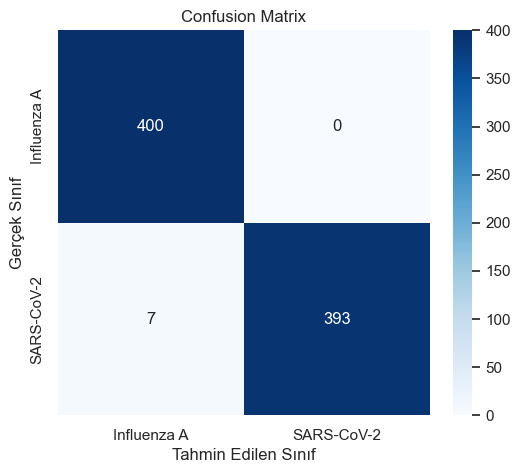

In [11]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Influenza A', 'SARS-CoV-2'], yticklabels=['Influenza A', 'SARS-CoV-2'])
plt.title("Confusion Matrix")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.show()


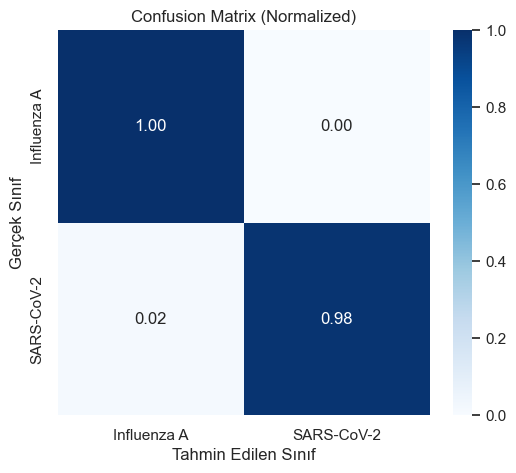

In [12]:
# Normalized Confusion Matrix
cm_normalized = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(6,5))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=['Influenza A', 'SARS-CoV-2'], yticklabels=['Influenza A', 'SARS-CoV-2'])
plt.title("Confusion Matrix (Normalized)")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.show()


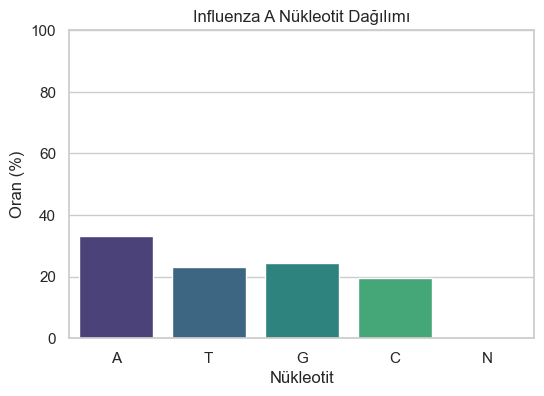

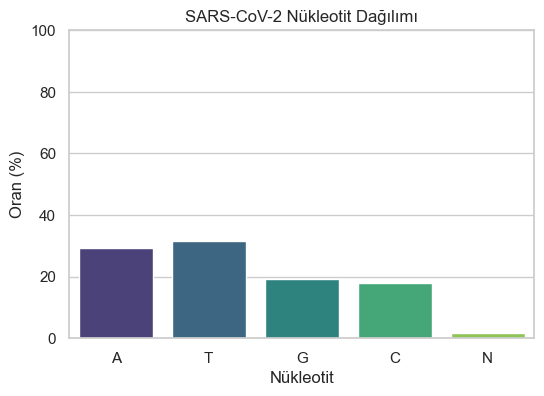

In [13]:
def plot_nucleotide_distribution(sequences, title="Nükleotit Dağılımı"):
    """
    'sequences': list of strings
    Her bir nükleotidin yüzdesel dağılımını hesaplayıp grafik çizer.
    """
    counts = {'A':0, 'T':0, 'G':0, 'C':0, 'N':0}
    total_len = 0
    for seq in sequences:
        total_len += len(seq)
        for ch in seq:
            if ch in counts:
                counts[ch] += 1

    if total_len == 0:
        dist = {k:0 for k in counts.keys()}
    else:
        dist = {k: (v / total_len) * 100 for k, v in counts.items()}

    plt.figure(figsize=(6,4))
    sns.barplot(x=list(dist.keys()), y=list(dist.values()), palette="viridis")
    plt.xlabel("Nükleotit")
    plt.ylabel("Oran (%)")
    plt.title(title)
    plt.ylim(0, 100)
    plt.show()

# Nükleotit dağılımını çizdir
plot_nucleotide_distribution(influenza_sequences, "Influenza A Nükleotit Dağılımı")
plot_nucleotide_distribution(sars_cov_2_sequences, "SARS-CoV-2 Nükleotit Dağılımı")


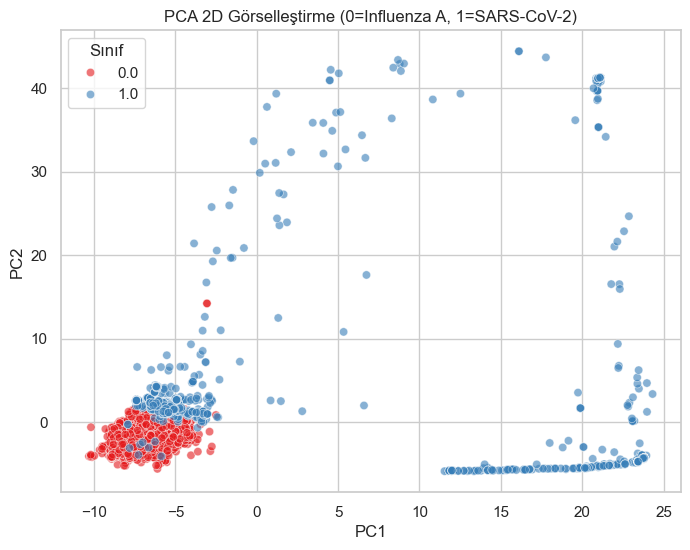

In [14]:
# PCA ile 2D indirgeme
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8,6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=y, palette="Set1", alpha=0.6)
plt.title("PCA 2D Görselleştirme (0=Influenza A, 1=SARS-CoV-2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Sınıf")
plt.show()


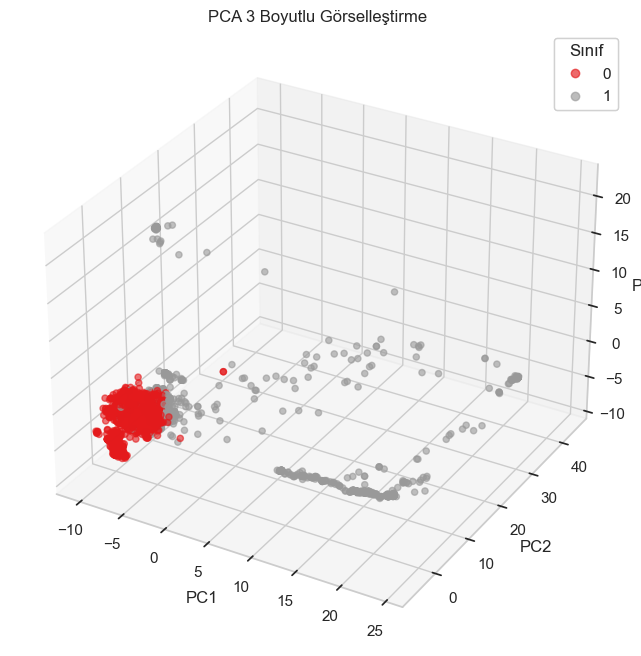

In [15]:
# 3D PCA
pca_3 = PCA(n_components=3)
X_pca_3d = pca_3.fit_transform(X)

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(X_pca_3d[:,0], X_pca_3d[:,1], X_pca_3d[:,2], c=y, cmap="Set1", alpha=0.6)
ax.set_title("PCA 3 Boyutlu Görselleştirme")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
legend1 = ax.legend(*scatter.legend_elements(),
                    title="Sınıf",
                    loc="upper right")
ax.add_artist(legend1)
plt.show()
